In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import matplotlib
import skimage

from collections import deque
from dataclasses import dataclass

c:\Users\thegr\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
from scipy.signal import butter, lfilter
def lpf(data, cutoff):
    b, a = butter(2, cutoff, fs = 25)
    y = lfilter(b, a, data)
    return y

In [3]:
@dataclass(frozen = True)
class MotionTrackingInfo:
    predicted: list
    actual: list

def motion_tracking(video: str, data: str, vid_path: str = "", save_video: bool = False):
    cap = cv.VideoCapture(video)
    tracking_data = open(data, "r")

    # Feature parameters
    feature_params = {
        "maxCorners": 100,
        "qualityLevel": 0.3,
        "minDistance": 7,
        "blockSize": 7 
    }

    # Lucas Kinade parameters
    lk_params = {
        "winSize": (25, 25),
        "maxLevel": 4,
        "criteria": (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03)
    }

    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    # Initialize flag to end viewing when q is pressed
    stop = False

    frame_number = 0

    vectors = []
    true_vectors = []
    tip_position = []

    initial_vals = [float(x) for x in tracking_data.readline().split(" ")[:2]]

    points = [deque(maxlen = 50) for _ in range(p0.shape[0])]

    if save_video:
        video_writer = cv.VideoWriter(vid_path,  
                                cv.VideoWriter_fourcc('M', 'J', 'P', 'G'), 
                                25, (old_gray.shape[1], old_gray.shape[0])) 

        video_writer.write(old_frame)

    while (not stop):
        ret,frame = cap.read()
        if frame is None:
            print("End of video, breaking")
            break
        
        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # calculate optical flow
        p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is None: 
            print("Failed to extract features")
            continue

        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]

        new_vals = [float(x) for x in tracking_data.readline().split(" ")[:2]]

        vectors.append(np.array(good_new) - np.array(good_old))
        true_vectors.append(np.array(new_vals) - np.array(initial_vals))
        tip_position.append(np.array(new_vals))
        initial_vals = new_vals

        try:
            norm = np.linalg.norm(vectors[-1], axis = 1)

            idxs = np.where(norm > np.mean(norm))[0]
            estimated_angle = \
                (np.median([np.arctan2(vectors[-1][:,1], vectors[-1][:,0])[i] for i in idxs]))
                # (np.average([np.arctan2(vectors[-1][:,1], vectors[-1][:,0])[i] for i in idxs]))
            
            estimated_magnitude = \
                np.median([norm[i] for i in idxs])
                # np.average([norm[i] for i in idxs])
            
            RED = (0, 0, 255)
            BLUE = (255, 0, 0)
            GREEN = (0, 255, 0)

            mask = np.zeros_like(old_frame)
            frame_copy = frame.copy()

            # Draw the tracks
            for i,(new,old) in enumerate(zip(good_new,good_old)):
                a,b = new.ravel()
                c,d = old.ravel()
                
                # Set values to integers to allow for drawing
                points[i].append((int(a), int(b), int(c), int(d)))

                for a, b, c, d in points[i]:
                    # mask = cv.line(mask, (a,b),(c,d), GREEN if i in idxs else RED, 1)
                    # frame_copy = cv.circle(frame_copy, (a,b), 3, GREEN if i in idxs else RED, -1)
                    mask = cv.line(mask, (a,b),(c,d), (127, 127, 127), 1)
                    frame_copy = cv.circle(frame_copy, (a,b), 3, (255, 255, 0), -1)
            
            # correct_magnitude.append(
            #     (np.linalg.norm(vec_true))
            # )

            img = cv.add(frame_copy, mask)

            # cv.arrowedLine(
            #     img, 
            #     (int(tip_position[-1][0]), int(tip_position[-1][1])), 
            #     (int(tip_position[-1][0] + min(estimated_magnitude*25, 100)*np.cos(estimated_angle)), int(tip_position[-1][1] + min(estimated_magnitude*25, 100)*np.sin(estimated_angle))),
            #     color = BLUE,
            #     thickness = 10,
            #     tipLength = 0.25
            # )
            if save_video:
                video_writer.write(img)
            
            frame_number += 1
            
            # cv.imshow("Frame", frame.copy())
            # cv.waitKey(0)
            # cv.destroyAllWindows()
            # if frame_number == 500:
            #     cv.imshow("Frame", img)
            #     cv.waitKey(0)
            #     cv.destroyAllWindows()
            #     break
            
            # while True:
            #     # Exit if 'q' is pressed
            #     if cv.waitKey(25) & 0xFF == ord('q'):
            #         stop = True
            #         break
            #     elif cv.waitKey(33) == 32: break
                                                                        
            # # Now update the previous frame and previous points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1,1,2)
        except Exception as e:
            print(f"Iteration failed: {e}")

    cap.release()
    if save_video:
        video_writer.release()
    cv.destroyAllWindows()
    
    return MotionTrackingInfo(predicted = vectors, actual = true_vectors)

In [4]:
info_2 = motion_tracking(
    video = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset2\\Video.avi",
    data = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset2\\Pose.txt"
)

info_3 = motion_tracking(
    video = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset3\\Video.avi",
    data = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset3\\Pose.txt"
)

info_4 = motion_tracking(
    video = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset4\\Video.avi",
    data = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset4\\Pose.txt"
)

End of video, breaking
End of video, breaking
End of video, breaking


In [5]:
predicted_full = info_2.predicted + info_3.predicted + info_4.predicted
actual_full = info_2.actual + info_3.actual + info_4.actual

actual_angles = []
predicted_magnitude = []
actual_magnitude = []
predicted_angles = []

for pred, actual in zip(predicted_full, actual_full):
    actual_angles.append(np.degrees(np.arctan2(actual[1], actual[0])))

    
    actual_magnitude.append(np.linalg.norm(actual))
    norm = np.linalg.norm(pred, axis = 1)
    
    idxs = np.where(norm > np.mean(norm))[0]
    predicted_angles.append(np.average(np.degrees([np.arctan2(pred[:,1], pred[:,0])[i] for i in idxs])))
    predicted_magnitude.append(np.average([norm[i] for i in idxs]))

indexes = (0, len(info_2.predicted), len(info_2.predicted)+len(info_3.predicted), len(info_2.predicted)+len(info_3.predicted)+len(info_4.predicted))

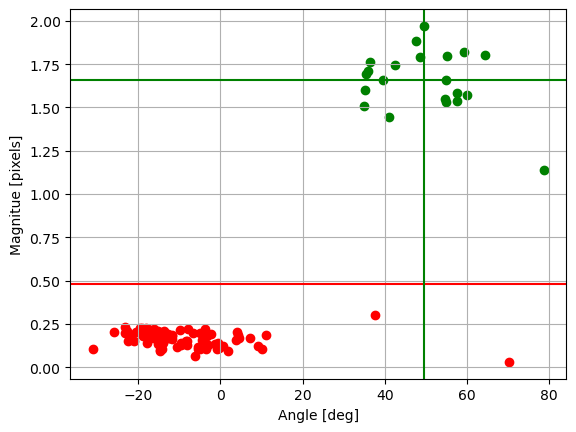

In [6]:
estimated_angles = []
correct_angles = []
estimated_magnitude = []
correct_magnitude = []

tip_vec = []

vec = info_2.predicted[499]
vec_true = info_2.actual[499]
norm = np.linalg.norm(vec, axis = 1)

# idxs = np.where(norm > 0.99*np.mean(norm))[0]
idxs = np.arange(len(vec))

estimated_angles = np.degrees([np.arctan2(vec[:,1], vec[:,0])[i] for i in idxs])

correct_angles.append(
    (np.arctan2(vec_true[1], vec_true[0]))
)

estimated_magnitude = [norm[i] for i in idxs]

correct_magnitude.append(
    (np.linalg.norm(vec_true))
)

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.scatter(estimated_angles, estimated_magnitude)
ax.axhline(np.average(estimated_magnitude), c = "red")
ax.scatter(
    [estimated_angles[i] for i in idxs if estimated_magnitude[i] > np.average(estimated_magnitude)], 
    [estimated_magnitude[i] for i in idxs if estimated_magnitude[i] > np.average(estimated_magnitude)],
    c = "green"
)

ax.scatter(
    [estimated_angles[i] for i in idxs if estimated_magnitude[i] <= np.average(estimated_magnitude)], 
    [estimated_magnitude[i] for i in idxs if estimated_magnitude[i] <= np.average(estimated_magnitude)],
    c = "red"
)

ax.axhline(np.median([estimated_magnitude[i] for i in idxs if estimated_magnitude[i] > np.average(estimated_magnitude)]), c = "green")
ax.axvline(np.median([estimated_angles[i] for i in idxs if estimated_magnitude[i] > np.average(estimated_magnitude)]), c = "green")
ax.set_ylabel("Magnitue [pixels]")
ax.set_xlabel("Angle [deg]")
ax.grid()
# plt.plot(correct_angles)

In [7]:
# example plots w/ dataset 2
estimated_angles = predicted_angles[0:indexes[1]]
correct_angles = actual_angles[0:indexes[1]]

# example plots w/ dataset 2
estimated_magnitude = predicted_magnitude[0:indexes[1]]
correct_magnitude = actual_magnitude[0:indexes[1]]

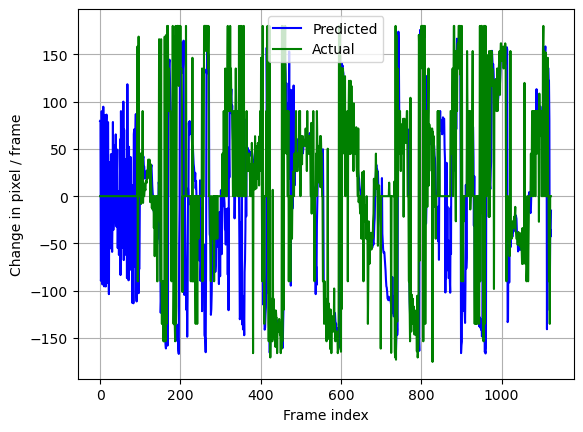

In [8]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(estimated_angles, alpha = 1.0, color = "blue", label = "Predicted")
ax.plot(correct_angles, alpha = 1.0, color = "green", label = "Actual")
ax.set_ylabel("Change in pixel / frame")
ax.set_xlabel("Frame index")
ax.set_axisbelow(True)
ax.grid()
ax.legend()

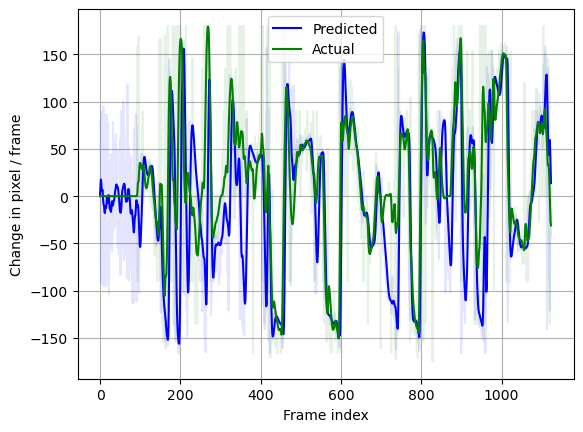

In [9]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(estimated_angles, color = "blue", alpha = 0.1)
ax.plot(correct_angles, color = "green", alpha = 0.1)
ax.plot(lpf(estimated_angles, 1.5), color = "blue", label = "Predicted")
ax.plot(lpf(correct_angles, 1.5), color = "green", label = "Actual")
ax.set_ylabel("Change in pixel / frame")
ax.set_xlabel("Frame index")
ax.set_axisbelow(True)
ax.grid()
ax.legend()


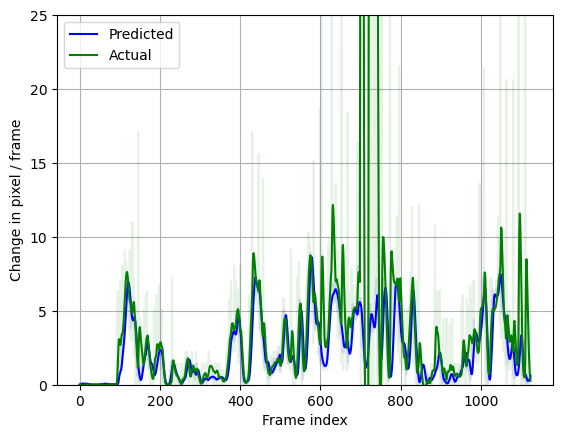

In [10]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((estimated_magnitude), alpha = 0.1, color = "blue")
ax.plot((correct_magnitude), alpha = 0.1, color = "green")
ax.plot(lpf((estimated_magnitude), 1.5), color = "blue", label = "Predicted")
ax.plot(lpf((correct_magnitude), 1.5), color = "green", label = "Actual")
ax.set_ylabel("Change in pixel / frame")
ax.set_xlabel("Frame index")
ax.set_axisbelow(True)
ax.set_ylim([0, 25])
ax.grid()
ax.legend()


14.229627505065366 54.5595504902438


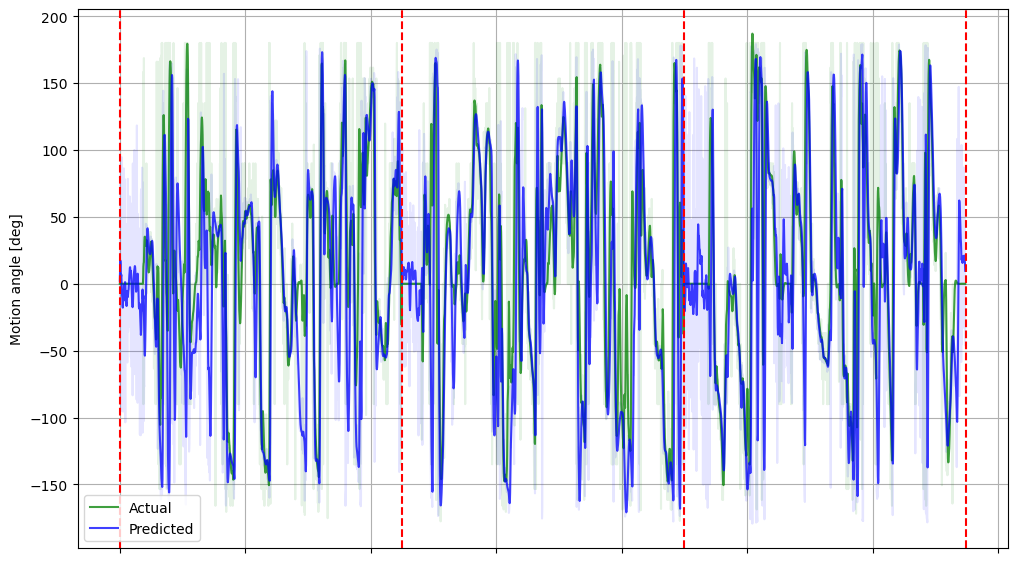

In [11]:
%matplotlib inline
fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(111)

ax.plot(actual_angles, alpha = 0.1, color = "green")
ax.plot(predicted_angles, alpha = 0.1, color = "blue")

actual_filt = np.concatenate([lpf(actual_angles[indexes[i]:indexes[i+1]], cutoff = 1.5) for i in range(len(indexes)-1)])
predicted_filt = np.concatenate([lpf(predicted_angles[indexes[i]:indexes[i+1]], cutoff = 1.5) for i in range(len(indexes)-1)])

ax.plot(actual_filt, alpha = 0.75, color = "green", label = "Actual")
ax.plot(predicted_filt, alpha = 0.75, color = "blue", label = "Predicted")

ax.set_ylabel("Motion angle [deg]")
ax.set_xticklabels([])
ax.legend()
ax.set_axisbelow(True)
ax.grid()
for i in indexes: ax.axvline(i, color = "red", linestyle = "dashed")

print(np.average(actual_filt-predicted_filt), np.std(actual_filt-predicted_filt))

2.3232292544754247 14.278567477631777


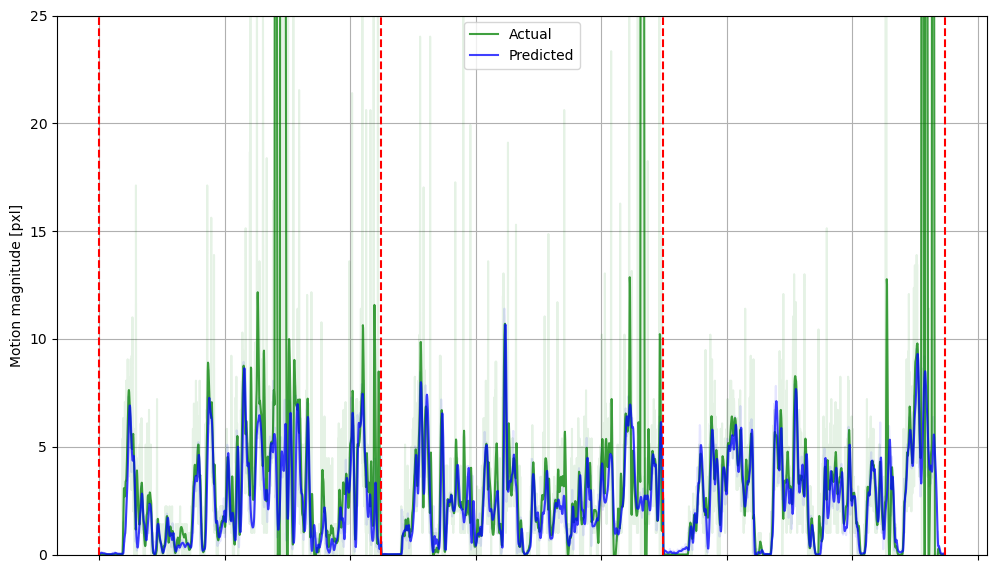

In [13]:
%matplotlib inline
fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(111)

ax.plot(actual_magnitude, alpha = 0.1, color = "green")
ax.plot(predicted_magnitude, alpha = 0.1, color = "blue")

actual_filt = np.concatenate([lpf(actual_magnitude[indexes[i]:indexes[i+1]], cutoff = 1.5) for i in range(len(indexes)-1)])
predicted_filt = np.concatenate([lpf(predicted_magnitude[indexes[i]:indexes[i+1]], cutoff = 1.5) for i in range(len(indexes)-1)])

ax.plot(actual_filt, alpha = 0.75, color = "green", label = "Actual")
ax.plot(predicted_filt, alpha = 0.75, color = "blue", label = "Predicted")

ax.set_ylabel("Motion magnitude [pxl]")
ax.set_xticklabels([])
ax.legend()
ax.set_axisbelow(True)
ax.set_ylim([0, 25])
ax.grid()
for i in indexes: ax.axvline(i, color = "red", linestyle = "dashed")

print(np.average(actual_filt-predicted_filt), np.std(actual_filt-predicted_filt))